<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [65]:
%cd /home/mffang/workspace/Poisson-regression

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)
from RADOM.inference import Trajectory
from RADOM.plotting import *
from RADOM.utils import *
from RADOM.models.two_species_ss import get_Y
from RADOM.mixtures import PoissonMixtureSS, PoissonMixture

/home/mffang/workspace/Poisson-regression
2023.09.01


In [66]:
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import velocyto as vcy
import scvelo as scv
import scanpy as sc
import copy
from multiprocessing import Pool
import cmasher as cmr
import pickle
import tqdm

In [4]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '36'
legend_font = '24'

In [5]:
def getNeighbors(embed, n_neigh=100, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(x1, x2, n_neigh=100, p=1):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    assert len(x1.shape) == 2
    assert len(x2.shape) == 2
    embed1_neighbor = getNeighbors(x1,n_neigh,p=p)
    embed2_neighbor = getNeighbors(x2,n_neigh,p=p)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        union = set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:])
        frac[i] = 1-len(inter)/len(union)
    return frac


In [6]:
def empirical_entropy(X):
    n, p ,s = X.shape
    entropy = np.zeros(p)
    n_bins = np.zeros(p)
    for j in range(p):
        bins = [ np.arange(X[:,j,0].min(),X[:,j,0].max()+2)-0.5, np.arange(X[:,j,1].min(),X[:,j,1].max()+2)-0.5]
        p, edges = np.histogramdd(X[:,j],bins=bins,density=True)
        entropy[j] = - np.sum(p[p>0] * np.log(p[p>0]))
        n_bins[j] = np.sum(p>0)
    return entropy, n_bins

# Generate clusters data

In [7]:
def simulate_static_data(n_states, n=10000, p=200, loga_mu=2, loga_sd=1, logb_mu=2, logb_sd=0.5, phi=0, random_seed=42, loomfilepath=None):    
    np.random.seed(random_seed)
    theta=np.zeros((p,n_states+2))
    for j in range(n_states):
        theta[:,j]=np.random.lognormal(loga_mu,loga_sd,size=p)
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    theta[:,-1]/=np.exp(1.5)
           
    Y = np.zeros((n_states,p,2))
    Y[:,:,0]=theta[:,:n_states].T
    Y[:,:,1]=(theta[:,-2]/theta[:,-1])[None,:]*Y[:,:,0]

    idx = np.random.randint(0,n_states,size=n)
    Z = Y[idx]
    
    if phi > 0:
        Z *= np.random.gamma(shape=1/phi,scale=phi,size=(n,p,2))

    rd_mu, rd_var = 0.25, 0.25
    a = (1-rd_mu)/rd_var - rd_mu
    b = (1/rd_mu-1)*a
    rd = np.random.beta(a=a, b=b, size=n)
    X = np.random.poisson(rd[:,None,None]*Z)
    
    if loomfilepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1))
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["true_time"]=idx
        adata.obs["cell_type"]=idx
        adata.obs["read_depth"]=rd
        adata.uns["true_theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write_loom(loomfilepath)

    return theta, idx, rd, Z, X,

# Our method

## Noise free data

In [8]:
true_theta, idx, rd, Y, X = simulate_static_data(4,n=10000,p=200,phi=0,loga_mu=1,random_seed=0,loomfilepath='data/simulation_4_clusters.loom')

In [118]:
adata = sc.read('data/simulation_4_clusters.loom')
n, p = adata.X.shape
X=np.zeros((n,p,2))
X[:,:,0]=adata.layers["unspliced"].toarray()
X[:,:,1]=adata.layers["spliced"].toarray()
print(X[:,:,0].mean(),X[:,:,1].mean())

true_time = adata.obs["true_time"]
rd = adata.obs["read_depth"]

0.140598 0.682786


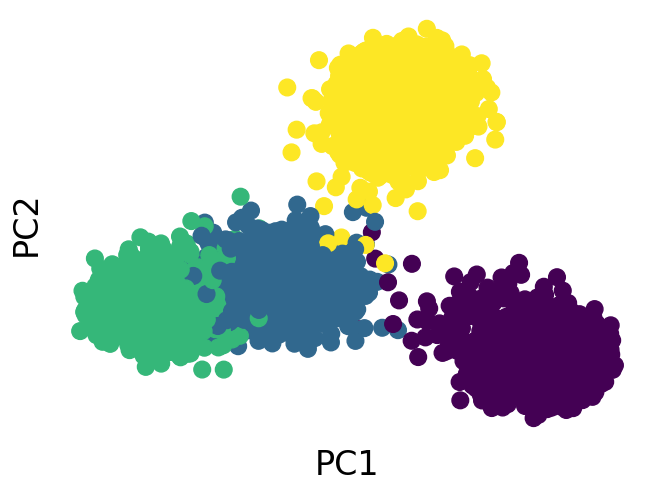

In [10]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1)
ax.scatter(x_pca[:,0],x_pca[:,1],c=adata.obs['cell_type']);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

```
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
params = {'r':rd/rd.mean(),'bnd_beta':1e6}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/negative.pickle', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)
```

In [113]:
with open('results/clusters/clusters_ri.pickle', 'rb') as f:
    trajs = pickle.load(f)

### AIC

In [114]:
corrs = []
AICs = []

for traj in trajs:
    weights = np.zeros_like(traj.Q)
    weights[:,:,0] = traj.Q.mean(0).sum(0)[0]
    weights[:,:,1:] = traj.Q.mean(0).sum(0)[1:].mean()
    weights[:,0] *= traj.Q.mean(0).sum(1)[0]
    weights[:,1] *= traj.Q.mean(0).sum(1)[1]
    traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X, standard=True) )
    
traj = trajs[np.argmin(AICs)]
right_t = traj.Q.sum(1) @ traj.t
for traj_ in trajs:
    t_hat = traj_.Q.sum(1) @ traj_.t
    corrs.append(stats.pearsonr(right_t,t_hat)[0])

In [119]:
n,p = X.shape[:2]
theta0 = np.zeros((p,5))
theta0[:,:4] = traj.theta[:,:4]
theta0[:,4] = traj.theta[:,-2]/traj.theta[:,-1]

PMSS = PoissonMixtureSS(n_components=4,verbose=1)
Q, lower_bound = PMSS.fit(X, warm_start=True, theta=theta0, read_depth=rd/rd.mean(), n_init=10, epoch=10)
PMSS.Q = Q
PMSS.elbo = lower_bound

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


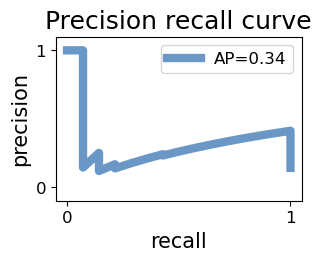

In [120]:
plt.rcParams['font.size'] = '12'

from sklearn.metrics import average_precision_score, precision_recall_curve

fig, ax = plt.subplots(1,1,figsize=(3,2.5))
is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="AP="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=12)
plt.ylabel('precision',fontsize=15)
plt.xlabel('recall',fontsize=15)
plt.title('Precision recall curve',fontsize=18)

plt.rcParams['font.size'] = '24'

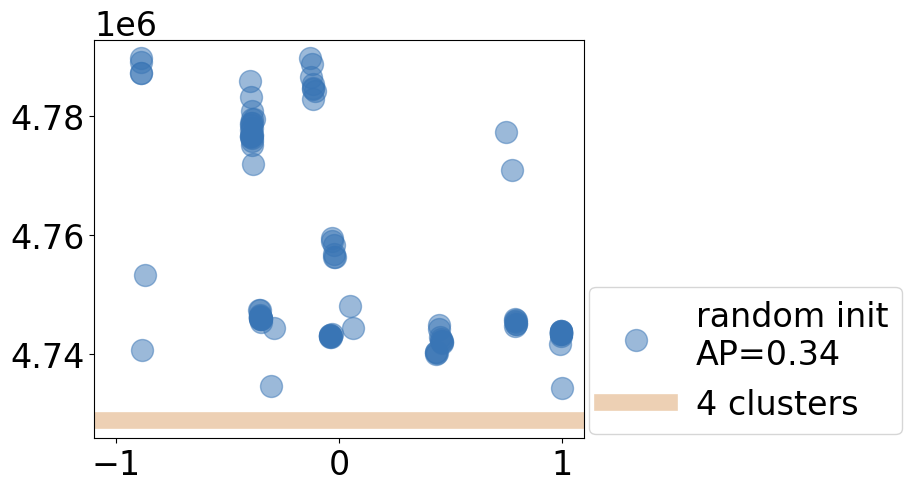

In [121]:
fig, ax = plt.subplots(1,1,figsize=(9,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(PMSS.compute_AIC(X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='4 clusters')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
#plt.xlabel('Correlation between inferred\ntime and warm start result',fontsize=label_font)
#plt.ylabel('ELBO',fontsize=label_font)
plt.legend(loc=(1.01,0.01),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

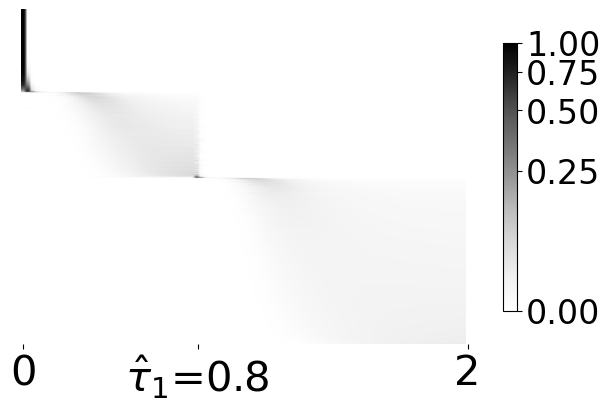

In [27]:
import matplotlib.colors as colors
def _forward(x):
    return np.log(0.1+x)

def _inverse(x):
    return np.exp(x)-0.1

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

plt.rcParams['font.size'] = '24'

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
cell_idx = np.argsort(t_hat)
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]

fig, ax = plt.subplots(1,1,figsize=(6,4))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(Z,aspect="auto",cmap='Greys', norm=norm);

plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1],1)), '2']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

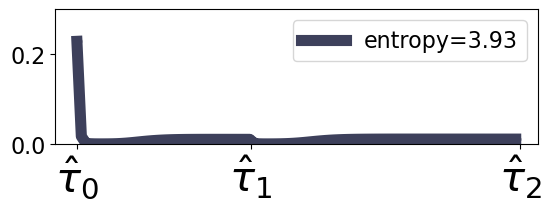

In [58]:
plt.rcParams['font.size'] = '16'
fig,ax = plt.subplots(figsize=(5.4,2))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8,\
        label="entropy="+str(np.around(stats.entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_ylim([0,0.3])
ax.legend()
plt.rcParams['font.size'] = '24'

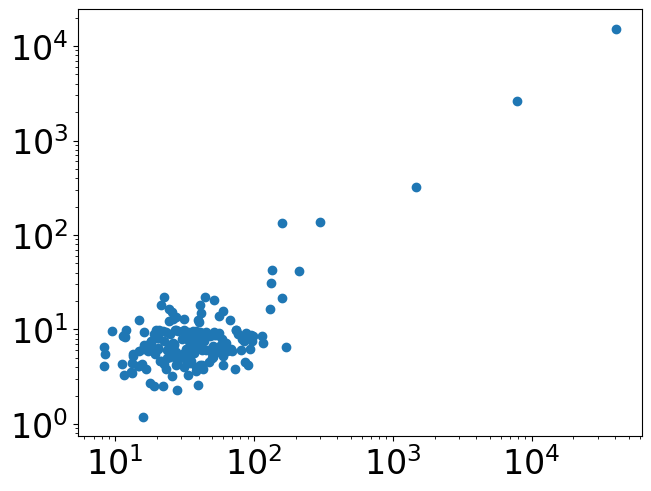

In [59]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')

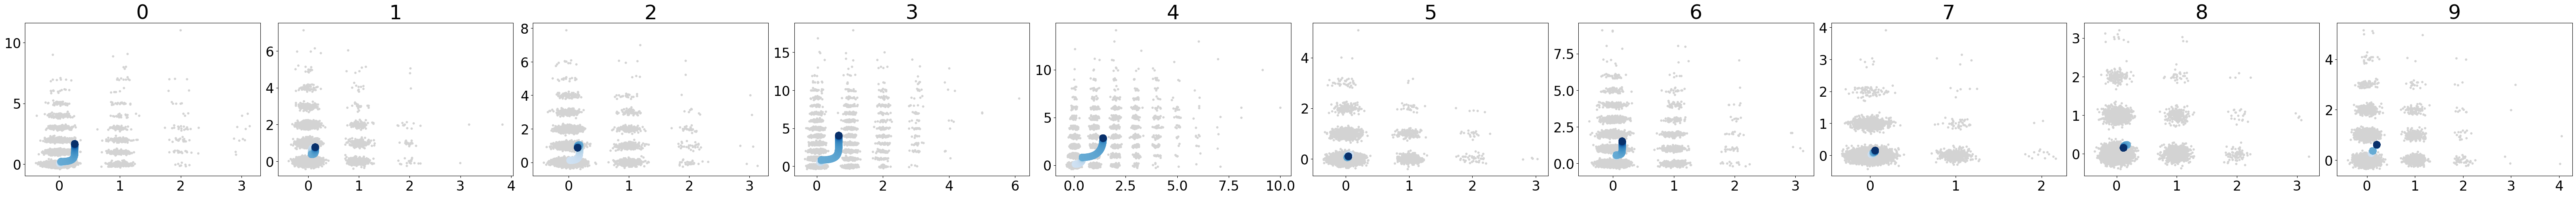

In [21]:
plot_phase(traj,idx=np.arange(10));

Text(0, 0.5, 'values')

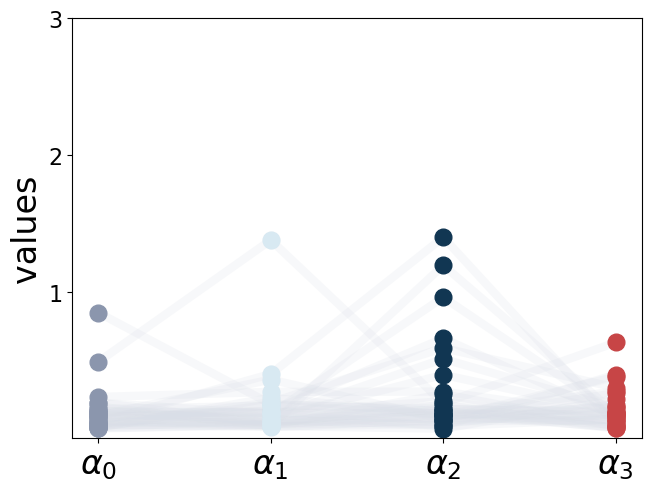

In [22]:
p = X.shape[1]
fig,ax = plt.subplots(1,1)
p_ = 30
for j in range(p_):
    ax.plot(traj.theta[j,[0,1,2,3]],'o-',color='#d9dee7',alpha=0.2)

colors=['#8b96ad','#d8e9f2','#113652','#c74546']
for j in range(4):
    ax.plot([j]*p_,traj.theta[:p_,j],'o',color=colors[j])
    

x_label_list = [r'$α_0$', r'$α_1$', r'$α_2$', r'$α_3$']
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(x_label_list,fontsize=24)

y_label_list = [1,2,3]
ax.set_yticks([1,2,3])
ax.set_yticklabels(y_label_list,fontsize=16)
ax.set_ylabel('values',fontsize=24)

### Model selection on 20 more samples

In [ ]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
r = rd/rd.mean()

Input_args = []

def fit_wrapper(seed):
    np.random.seed(seed)
    X_ = np.random.poisson(rd[:,None,None]*Y)
    
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_,warm_start=False,params=params,n_init=100, epoch=100, parallel=False)
    traj.true_theta = true_theta.copy()
    traj.true_time = idx.copy()

    PMSS = PoissonMixtureSS(n_components=4)
    Q, lower_bound = PMSS.fit(X_, warm_start=False, read_depth=r, n_init=10, epoch=10)
    
    return (PMSS,traj)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    models = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/negative_models.pickle', 'wb') as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

In [22]:
with open('results/negative_models.pickle', 'rb') as f:
    models = pickle.load(f)
    
AICs = []
PMSS_AICs = []

for model in tqdm.tqdm(models):
    PMSS,traj = model
    PMSS_AICs.append( PMSS.compute_AIC(traj.X,standard=True) )
    weights = np.ones(traj.m)
    weights[0] = traj.Q.mean(0).sum(0)[0]
    weights[1:] = traj.Q.mean(0).sum(0)[1:].mean()
    traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X,standard=True) )
AICs = np.array(AICs)
PMSS_AICs = np.array(PMSS_AICs)

100%|██████████| 20/20 [00:46<00:00,  2.31s/it]


(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

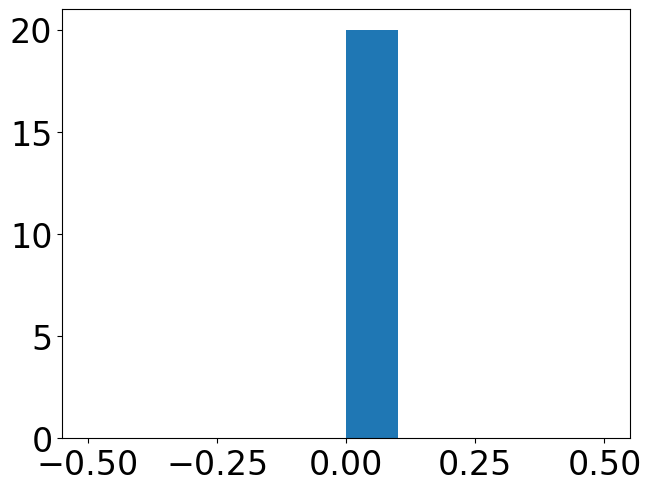

In [41]:
model = [np.argmin([PMSS_AICs[i],AICs[i]]) for i in range(20)]
plt.hist(model)

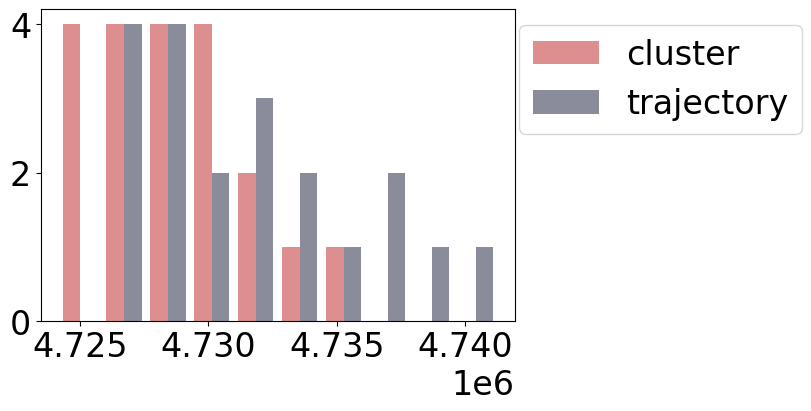

In [40]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
base = np.minimum(np.min(PMSS_AICs),np.min(AICs))
bins = np.linspace(np.minimum(np.min(PMSS_AICs),np.min(AICs)),np.maximum(np.max(PMSS_AICs),np.max(AICs)),11)
ax.hist([PMSS_AICs,AICs],color=['#c74546','#3d405b'],alpha=0.6,label=['cluster','trajectory'],bins=bins)
ax.legend(loc=(1.01,0.6),fontsize=legend_font);

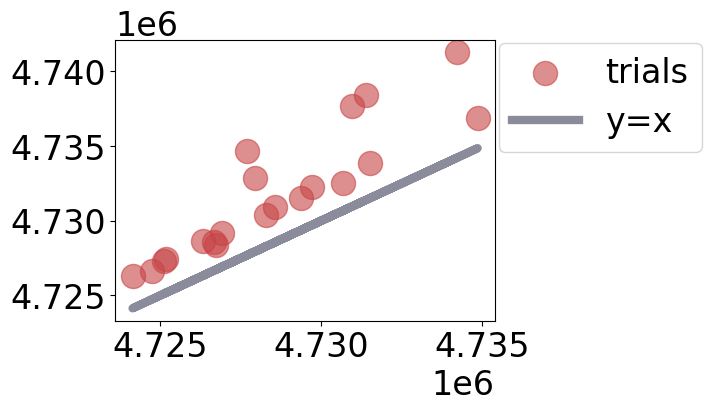

In [66]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(PMSS_AICs,AICs,color='#c74546',alpha=0.6,s=300,label='trials')
ax.plot(PMSS_AICs,PMSS_AICs,'#3d405b',alpha=0.6,label='y=x')
ax.legend(loc=(1.01,0.6),fontsize=legend_font);

In [587]:
from tqdm import tqdm

x = []
y = []
z = []
for model in tqdm(models):
    PMSS,traj = model
    AIC = []
    BIC = []
    ELBO = []
    
    AIC.append(PMSS.compute_AIC(traj.X,normalized=False))
    BIC.append(PMSS.compute_BIC(traj.X,normalized=False))
    ELBO.append(PMSS.compute_lower_bound(traj.X))
    
    AIC.append(traj.compute_AIC(traj.X,standard=True))
    BIC.append(traj.compute_BIC(traj.X,standard=True))
    ELBO.append(traj.compute_lower_bound(traj.X))

    x.append(np.argmin(AIC))
    y.append(np.argmin(BIC))
    z.append(np.argmax(ELBO))

100%|██████████| 100/100 [05:41<00:00,  3.41s/it]


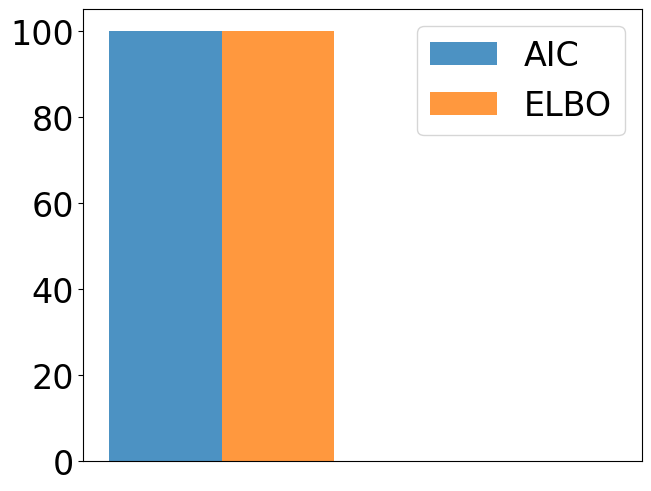

In [603]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.hist([x,z],label=["AIC","ELBO"],bins=np.arange(3)-0.5,alpha=0.8)#,color=['#233d4d','#fe7f2d']
x_label_list = ['4 clusters', 'trajectory']
#ax.set_xticks([0,1])
#ax.set_xticklabels(x_label_list,fontsize=label_font);
ax.set_xticks([])
ax.legend(fontsize=legend_font)

In [76]:
logL_out = []
for traj in trajs:
    traj.params['r'] = rd[test_index]/rd[train_index].mean()
    logL_out.append( traj.compute_lower_bound(X_test) )
logL_out = np.array(logL_out)

In [64]:
topo = np.array([[0,1]],dtype=int)
tau = np.array((0,1),dtype=float)

trajs=[]
logL_out=[]
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), np.zeros(n))):
    X_train = X[train_index]
    X_test = X[test_index]
    params = {'r':rd[train_index]/rd[train_index].mean()}
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
    traj = traj.fit(X_train,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    trajs.append(traj)
    traj.params['r'] = rd[test_index]/rd[train_index].mean()
    logL_out.append( traj.compute_lower_bound(X_test) )

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


In [9]:
logL_out_PM=[]
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), np.zeros(n))):
    X_train = X[train_index]
    X_test = X[test_index]
    PMSS = PoissonMixtureSS(n_components=3)
    Q, lower_bound = PMSS.fit(X_train, warm_start=False, read_depth=rd[train_index]/rd[train_index].mean(), n_init=5, epoch=10)
    PMSS.rd = rd[test_index]/rd[train_index].mean()
    logL_out_PM.append(PMSS.compute_lower_bound(X_test))

NameError: name 'skf' is not defined

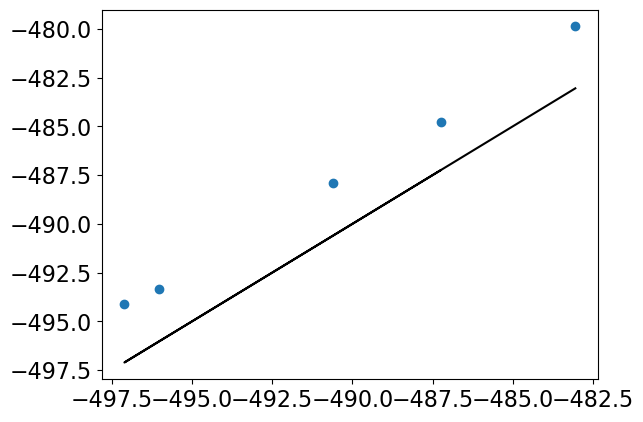

In [89]:
plt.plot(logL_out_PM,logL_out_PM,'k')
plt.scatter(logL_out_PM,logL_out)

In [9]:
topo = np.array([[0,1]],dtype=int)
tau = np.array((0,1),dtype=float)
params = {'r':rd[train_index]/rd[train_index].mean()}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_train,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

NameError: name 'train_index' is not defined

### Bootstrap 100 times

In [29]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
r = rd/rd.mean()

Input_args = []
def fit_wrapper(seed):
    np.random.seed(seed)
    bootstrap_idx = np.random.choice(n, size=n, replace=True)
    X_b = X[bootstrap_idx]

    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj)
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    bootstraps = pool.starmap(fit_wrapper, Input_args, chunksize=1)    

with open('results/negative_bs.pickle', 'wb') as f:
    pickle.dump(bootstraps, f, pickle.HIGHEST_PROTOCOL)

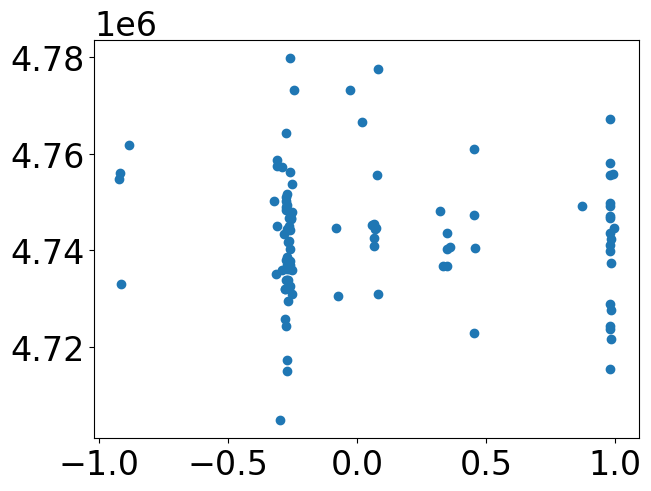

In [51]:
corrs_b = []
AICs = []

for bootstrap_idx,traj in bootstraps:
    ref_t = right_t[bootstrap_idx]
    t_hat = traj.Q.sum(1) @ traj.t
    corrs_b.append(stats.pearsonr(ref_t,t_hat)[0])
    AICs.append( traj.compute_AIC(traj.X, standard=True) )  
    
plt.plot(corrs_b,AICs,'.');

## Noisy data

In [59]:
true_theta, idx, rd, Y, X = simulate_static_data(4,n=10000,p=200,phi=1,loga_mu=1,random_seed=0,loomfilepath='data/simulation_4_clusters_noisy.loom')

In [81]:
adata = sc.read('data/simulation_4_clusters_noisy.loom')
n, p = adata.X.shape
X=np.zeros((n,p,2))
X[:,:,0]=adata.layers["unspliced"].toarray()
X[:,:,1]=adata.layers["spliced"].toarray()
print(X[:,:,0].mean(),X[:,:,1].mean())

true_time = adata.obs["true_time"]
rd = adata.obs["read_depth"]

0.1425635 0.6941025


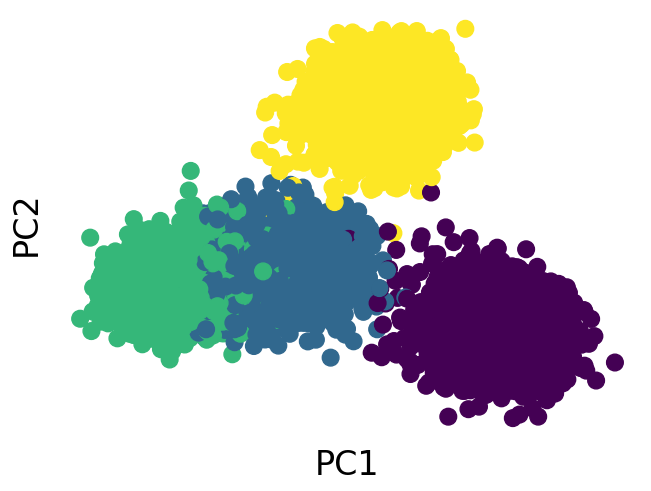

In [82]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1)
ax.scatter(x_pca[:,0],x_pca[:,1],c=adata.obs['cell_type']);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### Random initializations

In [ ]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
params = {'r':rd/rd.mean()}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/clusters/noisy_clusters_ri.pickle', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [75]:
with open('results/clusters/noisy_clusters_ri.pickle', 'rb') as f:
    trajs = pickle.load(f)

In [76]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)

corrs = []
AICs = []
K = len(tau)-1
for traj in trajs:
    weights = np.zeros_like(traj.Q)
    weights[:,:,0] = traj.Q.mean(0).sum(0)[0]
    weights[:,:,1:] = traj.Q.mean(0).sum(0)[1:].mean()
    weights[:,0] *= traj.Q.mean(0).sum(1)[0]
    weights[:,1] *= traj.Q.mean(0).sum(1)[1]
    traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X, standard=True) )
    
traj = trajs[np.argmin(AICs)]
right_t = traj.Q[:,0] @ traj.t
for traj_ in trajs:
    t_hat = traj_.Q[:,0] @ traj_.t
    corrs.append(stats.pearsonr(right_t,t_hat)[0])

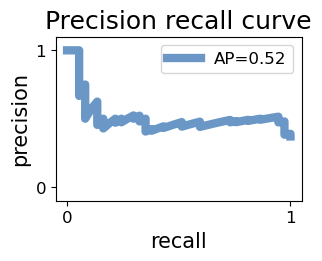

In [112]:
plt.rcParams['font.size'] = '12'

from sklearn.metrics import average_precision_score, precision_recall_curve

fig, ax = plt.subplots(1,1,figsize=(3,2.5))
is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="AP="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=12)
plt.ylabel('precision',fontsize=15)
plt.xlabel('recall',fontsize=15)
plt.title('Precision recall curve',fontsize=18)

plt.rcParams['font.size'] = '24'

In [84]:
n,p = X.shape[:2]
theta0 = np.zeros((p,5))
theta0[:,:4] = traj.theta[:,:4]
theta0[:,4] = traj.theta[:,-2]/traj.theta[:,-1]

PMSS = PoissonMixtureSS(n_components=4,verbose=1)
Q, lower_bound = PMSS.fit(X, warm_start=True, theta=theta0, read_depth=rd/rd.mean(), epoch=10)
PMSS.Q = Q
PMSS.elbo = lower_bound

read_depth is not normalized


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


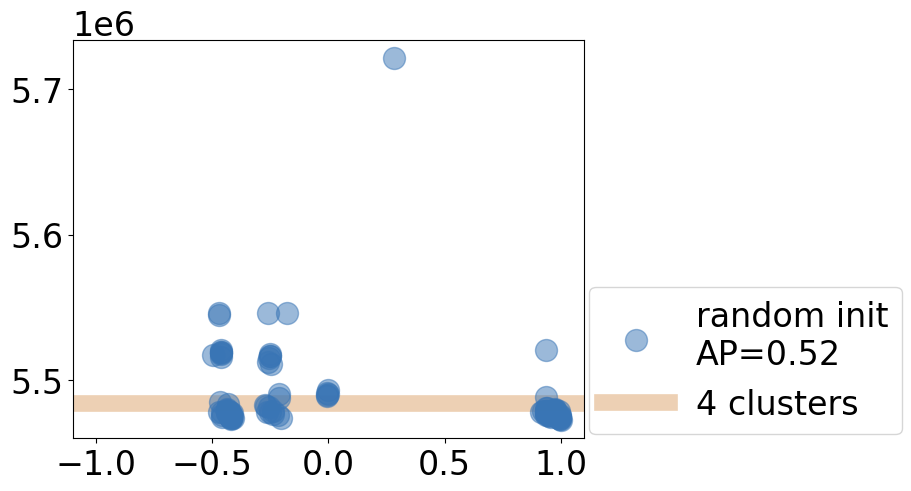

In [92]:
fig, ax = plt.subplots(1,1,figsize=(9,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(PMSS.compute_AIC(X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='4 clusters')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
#plt.xlabel('Correlation between inferred\ntime and warm start result',fontsize=label_font)
#plt.ylabel('ELBO',fontsize=label_font)
plt.legend(loc=(1.01,0.01),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

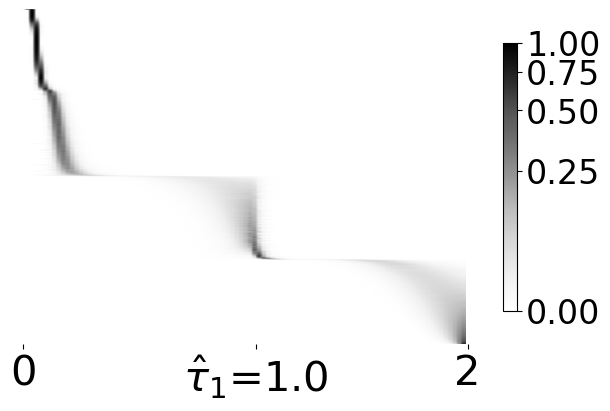

In [209]:
import matplotlib.colors as colors
def _forward(x):
    return np.log(0.1+x)

def _inverse(x):
    return np.exp(x)-0.1

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

plt.rcParams['font.size'] = '24'

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
cell_idx = np.argsort(t_hat)
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]

fig, ax = plt.subplots(1,1,figsize=(6,4))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(Z,aspect="auto",cmap='Greys', norm=norm);

plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1],1)), '2']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

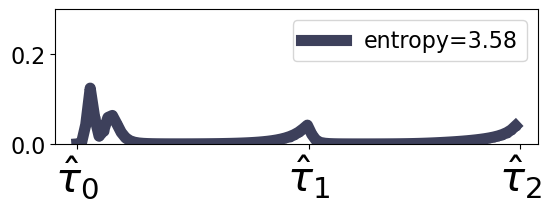

In [210]:
plt.rcParams['font.size'] = '16'
fig,ax = plt.subplots(figsize=(5.4,2))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8,\
        label="entropy="+str(np.around(stats.entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_ylim([0,0.3])
ax.legend()
plt.rcParams['font.size'] = '24'

### Model selection on 20 more samples

In [81]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
r = rd/rd.mean()
params = {'r':r}

Input_args = []

def fit_wrapper(seed):
    np.random.seed(seed)
    X_ = np.random.poisson(rd[:,None,None]*Y)
    
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_,warm_start=False,params=params,n_init=20, epoch=100, parallel=False)
    traj.true_theta = true_theta.copy()
    traj.true_time = idx.copy()

    PMSS = PoissonMixtureSS(n_components=4)
    Q, lower_bound = PMSS.fit(X_, warm_start=False, read_depth=r, n_init=10, epoch=10)
    
    return (PMSS,traj)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    models = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/negative_noisy_models.pickle', 'wb') as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

In [82]:
AICs = []
PMSS_AICs = []

for model in tqdm.tqdm(models):
    PMSS,traj = model
    PMSS_AICs.append( PMSS.compute_AIC(traj.X,standard=True) )
    weights = np.ones(traj.m)
    weights[0] = traj.Q.mean(0).sum(0)[0]
    weights[1:] = traj.Q.mean(0).sum(0)[1:].mean()
    traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X,standard=True) )
AICs = np.array(AICs)
PMSS_AICs = np.array(PMSS_AICs)

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


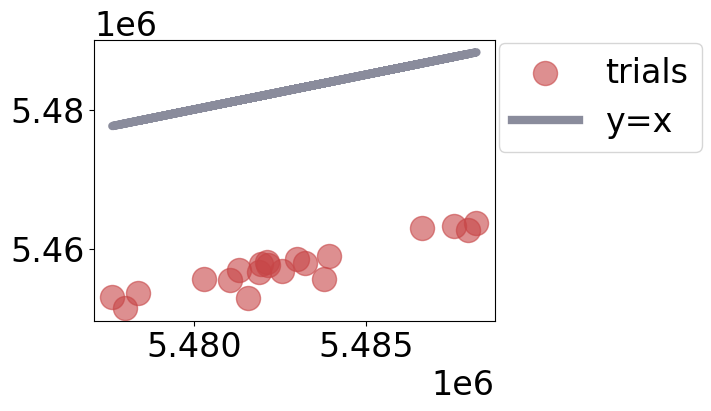

In [83]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(PMSS_AICs,AICs,color='#c74546',alpha=0.6,s=300,label='trials')
ax.plot(PMSS_AICs,PMSS_AICs,'#3d405b',alpha=0.6,label='y=x')
ax.legend(loc=(1.01,0.6),fontsize=legend_font);

### Bootstrap 100 times

In [63]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
r = rd/rd.mean()

Input_args = []
def fit_wrapper(seed):
    np.random.seed(seed)
    bootstrap_idx = np.random.choice(n, size=n, replace=True)
    X_b = X[bootstrap_idx]

    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj)
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    bootstraps = pool.starmap(fit_wrapper, Input_args, chunksize=1)    

with open('results/clusters/noisty_clusters_bs.pickle', 'wb') as f:
    pickle.dump(bootstraps, f, pickle.HIGHEST_PROTOCOL)

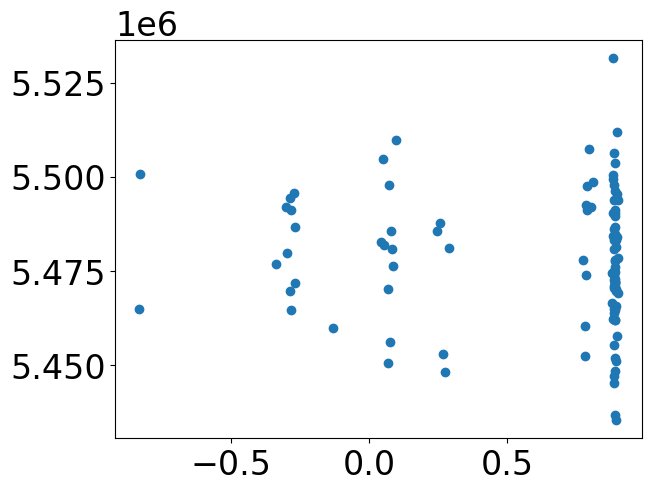

In [64]:
corrs_b = []
AICs = []

for bootstrap_idx,traj in bootstraps:
    ref_t = right_t[bootstrap_idx]
    t_hat = traj.Q.sum(1) @ traj.t
    corrs_b.append(stats.pearsonr(ref_t,t_hat)[0])
    AICs.append( traj.compute_AIC(traj.X, standard=True) )  
    
plt.plot(corrs_b,AICs,'.');

# Slingshot + tradeSeq

In [39]:
import rpy2
import rpy2.robjects as robjects

In [40]:
%load_ext rpy2.ipython

In [41]:
%%R 

library(tradeSeq, quietly = TRUE)
library(RColorBrewer, quietly = TRUE)
library(SingleCellExperiment, quietly = TRUE)
library(slingshot, quietly = TRUE)
library(umap, quietly = TRUE)
library(scran, quietly = TRUE)
library(scater, quietly = TRUE)
library(scuttle, quietly = TRUE)
library(Seurat, quietly = TRUE)
library(mclust, quietly = TRUE)

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    r


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: 
Attaching package: ‘scran’


R[write to console]: The following object is masked from ‘package:TrajectoryUtils’:

    createClusterMST


R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

R[write to console]: Attaching SeuratObject

R[write to console]: 
Attaching package: ‘Seurat’


R[write to console]: The following object is masked from ‘package:SummarizedExperiment’:

    Assays


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



In [52]:
adata = sc.read('data/simulation_4_clusters.loom')
X = adata.X.toarray()
n = len(X)

seed =0 
np.random.seed(seed)
bootstrap_idx = np.random.choice(n, size=n, replace=True)
counts = X[bootstrap_idx].T

In [53]:
%%R -i counts

set.seed(42)
sce <- SingleCellExperiment(assays = list(counts = counts))
sce <- logNormCounts(sce)
dec_sce <- modelGeneVar(sce)
hvgs <- getTopHVGs(dec_sce)
sce <- runPCA(sce, subset_row = hvgs)
sce <- runUMAP(sce, subset_row = hvgs)
rd = reducedDims(sce)$PCA

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



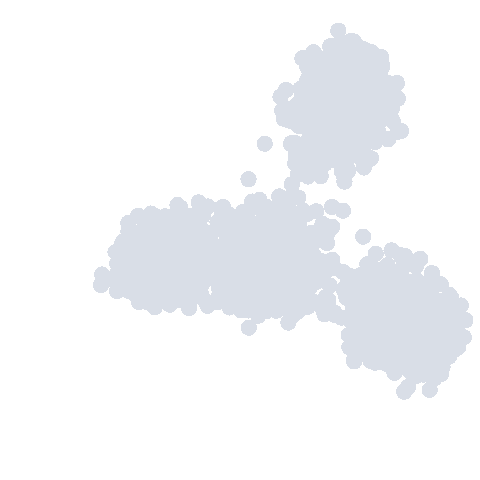

In [54]:
%%R
par(mar = c(4, 6, 0, 0))
plot(rd, col='#d9dee7', axes=F, pch=16, asp=1, cex=3, cex.lab=3, xlab='', ylab='')

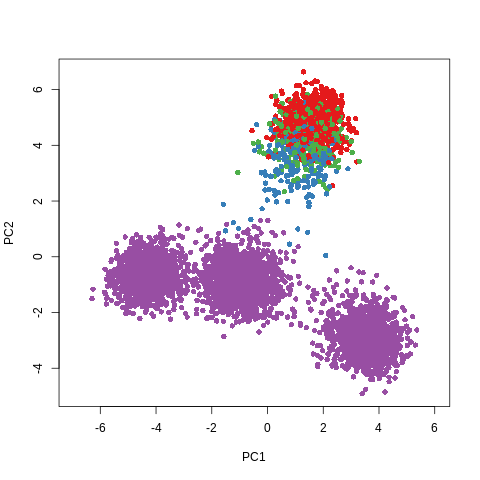

In [55]:
%%R
cl <- kmeans(rd, centers = 4)$cluster
colData(sce)$kmeans <- cl

plot(rd, col = brewer.pal(9,"Set1")[cl], pch=16, asp = 1)

In [56]:
%%R
# slingshot
sce <- slingshot(sce, clusterLabels = 'kmeans', reducedDim = 'PCA')

In [57]:
%%R

#pdf('principle_curve.pdf')
par(mar = c(4, 6, 0, 0))

weights = slingCurveWeights(sce)
weight = weights/rowSums(weights)
time1 = sce$slingPseudotime_1
time1[is.na(time1)] = 0
time2 = sce$slingPseudotime_2
time2[is.na(time2)] = 0
x_pca = reducedDims(sce)$PCA

In [58]:
time1 = robjects.r['time1']
time2 = robjects.r['time2']
weight = np.array(robjects.r['weight'])
x_pca = np.array(robjects.r['x_pca'])
cmap_1 = cmr.get_sub_cmap('Blues', 0.2, 1)
cmap_2 = cmr.get_sub_cmap('Reds', 0.2, 1)

color_1 = weight[:,0,None]*np.array(cmap_1(time1/np.max(time1)))[:,:3]
color_2 = weight[:,1,None]*np.array(cmap_2(time2/np.max(time2)))[:,:3]
t_color = color_1 + color_2

plotcol = []
for (r,g,b) in t_color:
    plotcol.append('#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)))
    
fig, ax = plt.subplots(1,1)
im=ax.scatter(x_pca[:,0],x_pca[:,1],c=plotcol);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
#plt.colorbar(im,fraction=0.05, shrink=0.9) # adding the colobar on the right

IndexError: index 1 is out of bounds for axis 1 with size 1

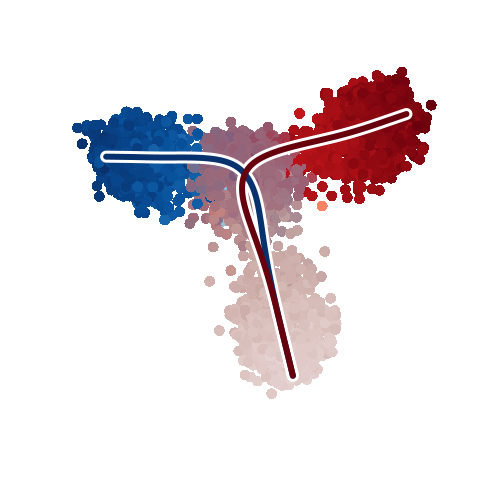

In [49]:
%%R -i plotcol

plot(reducedDims(sce)$PCA, col=plotcol, axes=F, pch=16, asp=1, cex=2, xlab='', ylab='')
#points(reducedDims(sce)$PCA, col=col2, pch=16, asp=1, cex=2)
lines(slingCurves(sce)[[1]], lwd=16, col = 'white')
lines(slingCurves(sce)[[2]], lwd=16, col = 'white')
lines(slingCurves(sce)[[1]], lwd=8, col = '#08326e')
lines(slingCurves(sce)[[2]], lwd=8, col = '#67000d')
#axis(side = 1)

In [ ]:
time1 = robjects.r['time1']
time2 = robjects.r['time2']
x_pca = np.array(robjects.r['x_pca'])

color_1 = weight[:,0,None]*np.array(cmap_1(time1/np.max(time1)))[:,:3]
color_2 = weight[:,1,None]*np.array(cmap_2(time2/np.max(time2)))[:,:3]
t_color = color_1 + color_2

fig, ax = plt.subplots(1,1)
im=ax.scatter(x_pca[:,0],x_pca[:,1],color='#d9dee7');
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
#plt.colorbar(im,fraction=0.05, shrink=0.9) # adding the colobar on the right

In [141]:
%%R
# fit negative binomial GAM
sce <- fitGAM(sce)

# test for dynamic expression
ATres <- associationTest(sce)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02m 43s       |+                                                 | 2 % ~02m 07s       |++                                                | 3 % ~01m 57s       |++                                                | 4 % ~01m 50s       |+++                                               | 5 % ~01m 53s       |+++                                               | 6 % ~01m 48s       |++++                                              | 7 % ~01m 44s       |++++                                              | 8 % ~01m 46s       |+++++                                             | 9 % ~01m 43s       |+++++                                             | 10% ~01m 41s       |++++++                                            | 11% ~01m 44s       |++++++                                            | 12% ~01m 42s       |+++++++                                           | 13% ~01m 

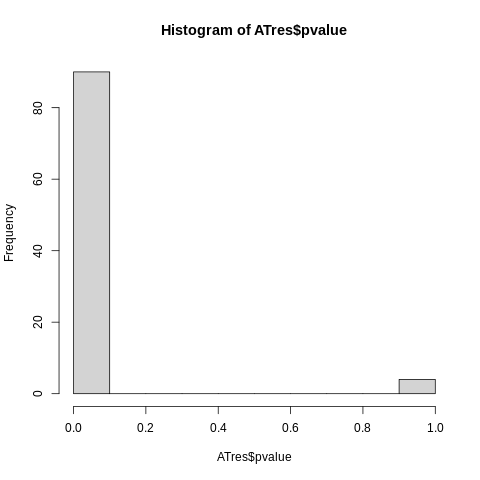

In [142]:
%%R
pvalue = ATres$pvalue
hist(ATres$pvalue)

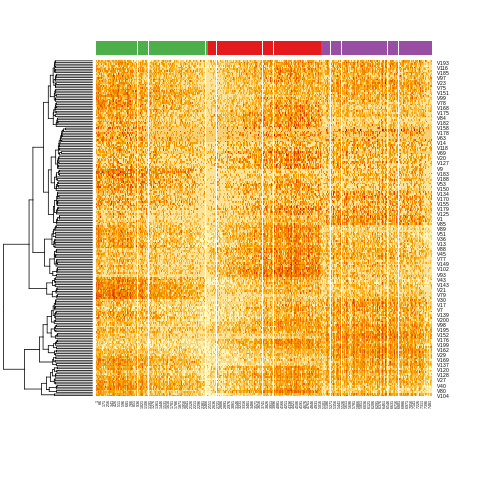

In [143]:
%%R
topgenes <- rownames(ATres[order(ATres$pvalue), ])[1:200]
pst.ord <- order(sce$slingPseudotime_1, na.last = NA)
heatdata <- assays(sce)$counts[topgenes, pst.ord]
heatclus <- sce$kmeans[pst.ord]

heatmap(log1p(heatdata), Colv = NA,
        ColSideColors = brewer.pal(9,"Set1")[heatclus])
pst.ord

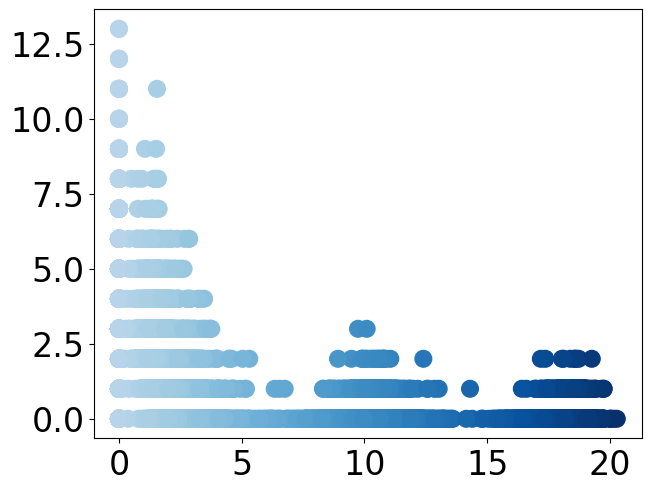

In [667]:
ptime = time1 #weight[:,0]*time1/np.max(time1)+weight[:,1]*time2/np.max(time2)
color1 = cmap_1(time1/np.max(time1))
j = 156
plt.scatter(ptime,counts[j].flatten(),c=color1)

# Other methods

## velocyto

https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/hgForebrainGlutamatergic.ipynb

In [ ]:
from sklearn.manifold import TSNE
from umap import UMAP

def run_velocyto(loomfile,quiver_scale="auto"):
    vlm = vcy.VelocytoLoom(loomfile)
    # Preliminary Filtering
    vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
    vlm.set_clusters(vlm.ca["cell_type"])
    #vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
    #vlm.filter_genes(by_detection_levels=True)
    #vlm.score_cv_vs_mean(100, plot=False, max_expr_avg=35)
    #vlm.filter_genes(by_cv_vs_mean=True)
    vlm._normalize_S(relative_size=vlm.S.sum(0),
                 target_size=vlm.S.sum(0).mean())
    vlm._normalize_U(relative_size=vlm.U.sum(0),
                 target_size=vlm.U.sum(0).mean())
    # Preparation for gamma fit
    vlm.perform_PCA()
    vlm.knn_imputation(n_pca_dims=20)
    # Gamma fit and extrapolation
    vlm.normalize_median()
    vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)
    vlm.normalize(which="imputed", size=False, log=True)
    vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift(assumption="constant_velocity")
    vlm.extrapolate_cell_at_t(delta_t=1.)
    # Projection of velocity onto embeddings
    #vlm.ts = TSNE().fit_transform(vlm.pcs[:, :25])
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="sqrt", knn_random=True, sampled_fraction=0.5)
    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)
    vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25))

    #vlm.colorandum = vlm.ca["time"]
    vlm.plot_grid_arrows(quiver_scale=quiver_scale,plot_random=True)
    
    #fig = plt.figure()
    #plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.gammas,'.');
    #plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.ra["true_gamma"]/vlm.ra["true_beta"],'r-');
    #plt.xscale('log')
    #plt.yscale('log')
    return vlm

In [ ]:
vlm = run_velocyto("data/simulation_4_clusters.loom",quiver_scale=0.1)

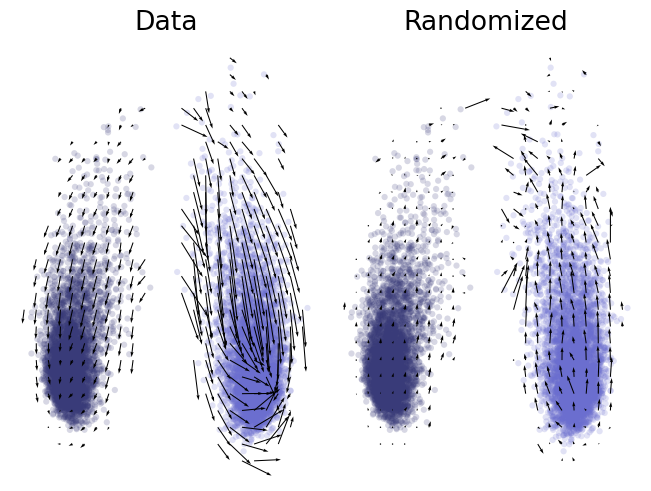

In [60]:
run_velocyto("data/simulation_2_clusters_noisy.loom",quiver_scale=0.1)

## cell2fate

In [8]:
import cell2fate as c2f

Global seed set to 0


AttributeError: module 'jax.tree_util' has no attribute 'register_pytree_with_keys_class'

In [ ]:
adata = sc.read('data/simulation_2_clusters_noisy.loom')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 1000, cluster_column = 'cell_type',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 0, n_var_genes= 200)

## scvelo

https://scvelo.readthedocs.io/en/stable/DynamicalModeling/

In [1239]:
def run_scvelo(loomfile):
    adata = scv.read_loom(loomfile)
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=200)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis='umap')
    scv.tl.latent_time(adata)
    scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)
    top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
    scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

    idx = adata.var['velocity_genes']
    if dynamical:
        true_gamma = adata.var['gamma']
        true_beta = adata.var['beta']
        betas = adata.var['fit_beta']
        gammas = adata.var['fit_gamma']
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        ax[0].plot(true_beta[idx],betas[idx],'.');
        ax[0].plot(true_beta[idx],true_beta[idx],'r-');
        ax[1].plot(true_gamma[idx],gammas[idx],'.');
        ax[1].plot(true_gamma[idx],true_gamma[idx],'r-');
    else:
        true_gamma = adata.var['gamma']/adata.var['beta']
        gammas = adata.var['velocity_gamma']
        plt.plot(true_gamma[idx],gammas[idx],'.');
        plt.plot(true_gamma[idx],true_gamma[idx],'r-');
    
    plt.xscale('log')
    plt.yscale('log')
    return adata
  

In [1241]:
run_scvelo("data/simulation_clusters_1.loom")

Filtered out 2 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 200 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/88 cores)
The correlation threshold has been reduced to -0.2051.
Please be cautious when interpreting results.


  0%|          | 0/40 [00:00<?, ?gene/s]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

# CEM vs EM

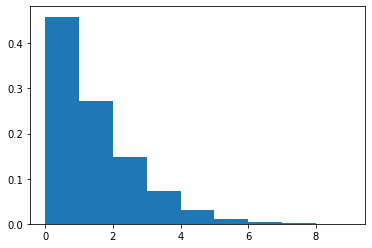

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N=100000
c=0.2
z=np.random.uniform(0,10,size=N)
y=np.random.poisson(z)
x=np.random.poisson(c*y)
plt.hist(x,bins=np.arange(0,10),density=True);

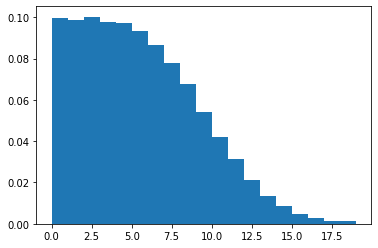

In [ ]:
plt.hist(y,bins=np.arange(0,20),density=True);

In [ ]:
def CEM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    Q = np.mean(np.amax(ll,axis=1))
    return Q

In [ ]:
n=51
thetas = np.linspace(1,5,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=CEM_Q(thetas[i],x)

5.0


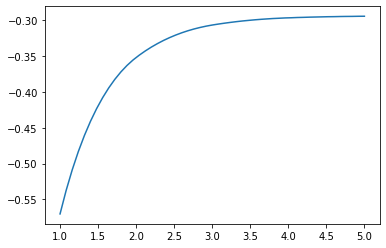

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
from scipy.special import softmax

def EM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)
    h=h[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    q=softmax(ll,axis=1)
    Q=np.mean(np.sum(q*ll-q*np.log(q+eps),axis=1))
    return Q

In [ ]:
n=21
thetas = np.linspace(1.9,2.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],x)

2.0300000000000002


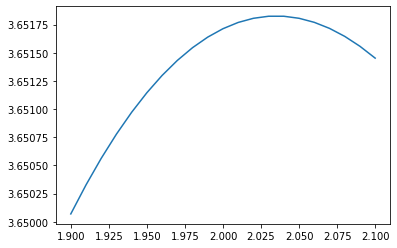

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
n=21
thetas = np.linspace(9.9,10.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],y)

10.02


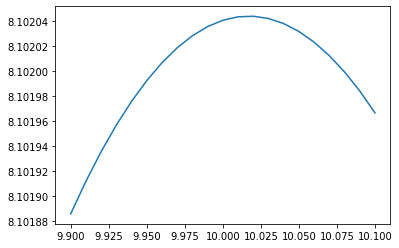

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

# Toggle switch

\begin{align}
&\frac{du_1}{dt} = \frac{\alpha_1}{1 + (s_3/k_1)^n} - \beta_1 u_1,\\[1em]
&\frac{ds_1}{dt} = \beta_1 u_1 - \gamma_1 s_1,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_2}{1 + (s_1/k_1)^n} - \beta_2 u_2,\\[1em]
&\frac{ds_2}{dt} = \beta_2 u_2 - \gamma_2 s_2,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_3}{1 + (s_3/k_1)^n} - \beta_3 u_3,\\[1em]
&\frac{ds_2}{dt} = \beta_3 u_3 - \gamma_2 s_3.
\end{align}

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [43]:
def repressilator(t, y, alpha_1, alpha_2, alpha_3, beta_1, beta_2, beta_3, gamma_1, gamma_2, gamma_3, k, n): 
    u_1, s_1, u_2, s_2, u_3, s_3  = y
    du_1_dt = alpha_1/(1 + (s_3/k)**n) - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2/(1 + (s_1/k)**n) - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2
    du_3_dt = alpha_3/(1 + (s_1/k)**n) - beta_3 * u_3
    ds_3_dt = beta_3 * u_3 - gamma_3 * s_3

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt, du_3_dt, ds_3_dt]

In [72]:
def toggle_switch(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k, n): 
    u_1, s_1, u_2, s_2 = y
    du_1_dt = alpha_1/(1 + (s_2/k)**n) - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2/(1 + (s_1/k)**n) - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [18]:
def piecewise(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n): 
    u_1, s_1, u_2, s_2 = y
    if t>0.03:
        alpha_1 = 0.032
    """ 
    if (s_2/k_1)**n > 1:
    alpha_1 = 0
    if (s_1/k_2)**n > 1:
    alpha_2 = 0
    """
    du_1_dt = alpha_1 - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2 - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [73]:
# Parameters
alpha_1 = 100
alpha_2 = 100
alpha_3 = 100
beta_1 = 10
beta_2 = 10
beta_3 = 10
gamma_1 = 10
gamma_2 = 10
gamma_3 = 10
k = 4
n = 3

func_args = (alpha_1, alpha_2, alpha_3, beta_1, beta_2, beta_3, gamma_1, gamma_2, gamma_3, k, n)
func_args = (alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k, n)

In [74]:
T=1
n=1000
#sol_repressilator = solve_ivp(repressilator, [0, T], [10, 10, 0, 0, 5, 5], args=func_args, t_eval = np.linspace(0,T,n))
sol_toggle_switch = solve_ivp(toggle_switch, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))
#sol_piecewise = solve_ivp(piecewise, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

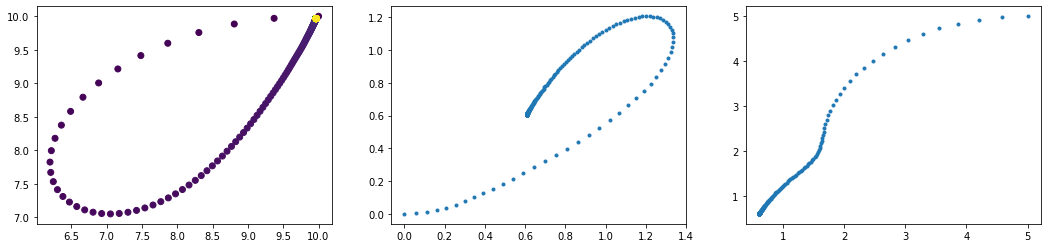

In [71]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].scatter(sol_repressilator.y[0],sol_repressilator.y[1],c=np.linspace(0,T,n));
ax[1].plot(sol_repressilator.y[2],sol_repressilator.y[3],'.');
ax[2].plot(sol_repressilator.y[4],sol_repressilator.y[5],'.');
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

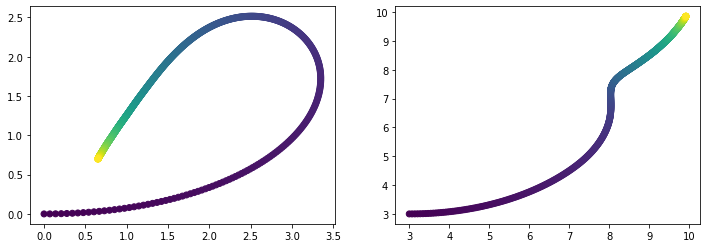

In [80]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n));
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n));
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

In [25]:
X=np.zeros((n,3,2))
X[:,0,:] = np.random.poisson(sol_repressilator.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_repressilator.y[2:4,:].T)
X[:,2,:] = np.random.poisson(sol_repressilator.y[4:,:].T)

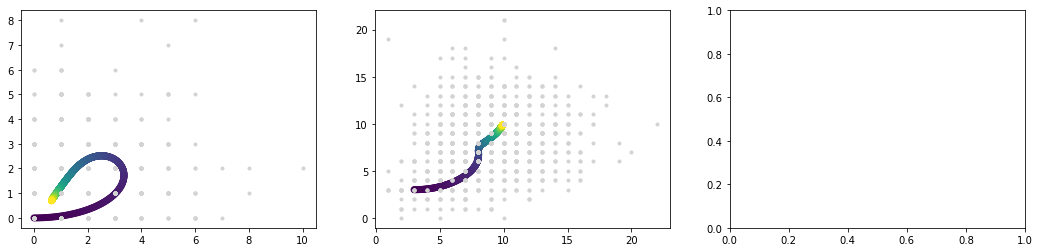

In [83]:
X=np.zeros((n,2,2))
X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:4,:].T)

fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n));
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n));


ax[0].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[1].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');


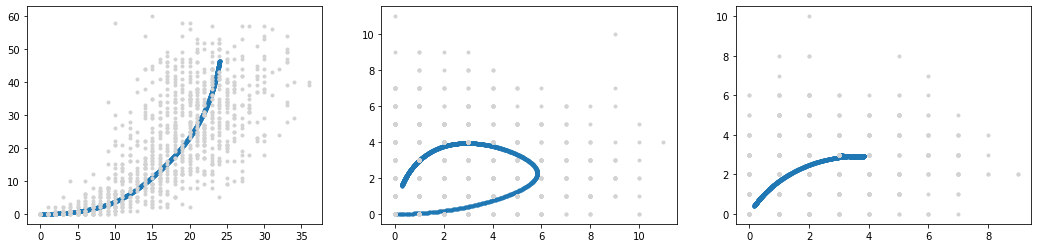

In [26]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(sol_repressilator.y[0],sol_repressilator.y[1],'.');
ax[1].plot(sol_repressilator.y[2],sol_repressilator.y[3],'.');
ax[2].plot(sol_repressilator.y[4],sol_repressilator.y[5],'.');

ax[0].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[1].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');
ax[2].plot(X[:,2,0],X[:,2,1],'.',color='lightgray');

In [ ]:
Y=np.zeros((n,2,2))
Y_=np.zeros((n,2,2))
Y[:,0,:] = sol_toggle_switch.y[0:2,:].T
Y[:,1,:] = sol_toggle_switch.y[2:,:].T
Y_[:,0,:] = sol_piecewise.y[0:2,:].T
Y_[:,1,:] = sol_piecewise.y[2:,:].T

In [ ]:
logL = np.sum(X*np.log(Y+1e-6)-Y)

In [ ]:
logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)

In [ ]:
logL, logL_

(19345.1814616582, 13911.119512963363)

In [ ]:
for seed in range(10):
  np.random.seed(seed)
  X=np.zeros((n,2,2))
  X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
  X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:,:].T)
  logL = np.sum(X*np.log(Y+1e-6)-Y)
  logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)
  print(logL, logL-logL_)


18880.03571626807 5324.7042063090485
19724.00254796687 5387.765836425984
19336.116476591138 5456.129096193097
19305.694539013144 5396.7025164842125
19103.44532761584 5333.563512339071
20141.930441571225 5433.368832422024
19846.408754534918 5228.998521898915
19225.844159742093 5459.7499646718425
19235.319949735633 5410.745083105829
19578.211082575617 5464.637577697415


## Fit toggle switch with piecewise

In [115]:
Q0 = np.diag(np.ones(n))

In [118]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species",verbose=1)
traj = traj.fit(X,Q=Q0[:,None],m=100,n_init=10,epoch=100,parallel=False,n_threads=1)

run method fit_warm_start


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


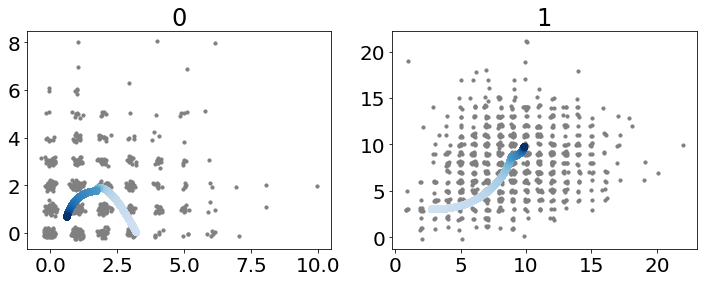

In [119]:
import matplotlib
matplotlib.rc('font', size=20)
fig, ax = plot_phase(traj,X=X,idx=np.arange(2))

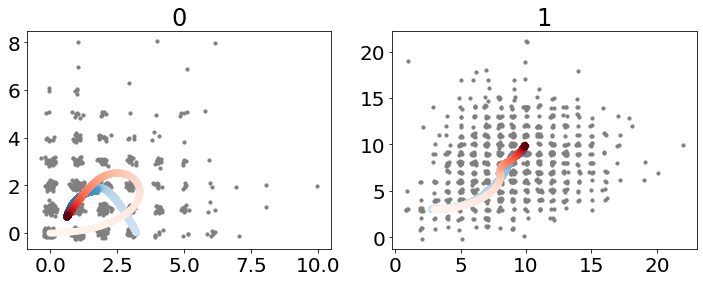

In [120]:
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n),cmap="Reds",alpha=1);
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n),cmap="Reds",alpha=1);
fig

<AxesSubplot:>

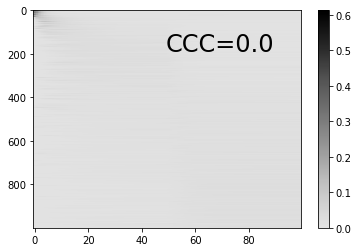

In [90]:
plot_t(traj,t=np.linspace(0,T,n))

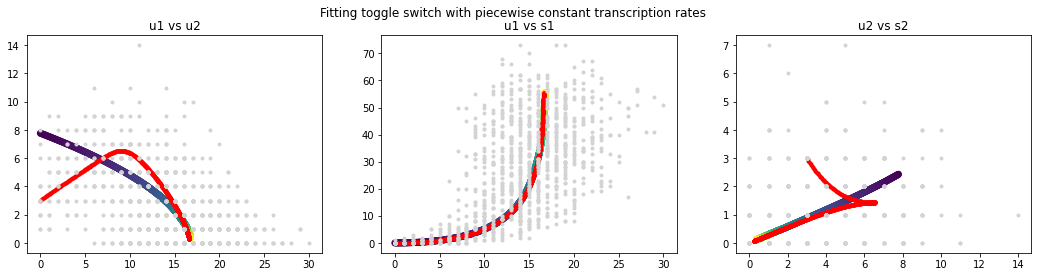

In [ ]:
t = traji.Q[:,0]@traji.t

fig, ax = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("Fitting toggle switch with piecewise constant transcription rates")

ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'r.');
ax[0].set_title("u1 vs u2")
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'r.');
ax[1].set_title("u1 vs s1")
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'r.');
ax[2].set_title("u2 vs s2")

ax[0].plot(X[:,0,0],X[:,1,0],'.',color='lightgray');
ax[1].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[2].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');

ax[0].scatter(Y_fit[:,0,0],Y_fit[:,1,0],c=t);
ax[1].scatter(Y_fit[:,0,0],Y_fit[:,0,1],c=t);
ax[2].scatter(Y_fit[:,1,0],Y_fit[:,1,1],c=t);

In [ ]:
theta_hat

array([[16.52106173, 16.83319367,  0.        ,  0.        ,  5.82877743,
         0.93046774],
       [ 0.18237896,  0.        ,  7.77194007,  2.43075787,  3.11594158,
        13.72520698]])